In [1]:
%matplotlib notebook

from gamesopt.train import train, TrainConfig
from gamesopt.games import load_game, GameOptions, QuadraticGameConfig, GameType
from gamesopt.games.quadratic_games import make_random_matrix
from gamesopt.optimizer import load_optimizer, OptimizerOptions, OptimizerType
from gamesopt.optimizer.prox import ProxOptions, ProxType
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
from gamesopt.db import Database
from pathlib import Path

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})

width = 487.8225
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

def plot_record(record_id, *args, **kwargs):
    record = db.getRecord(record_id)
    plt.plot(record.metrics.num_grad, record.metrics.dist2opt, *args, **kwargs)

In [3]:
torch.manual_seed(1234)
options = QuadraticGameConfig(num_samples = 100, dim = 20)
m_0 = make_random_matrix(options.num_samples-50, options.num_players*options.dim, ell=1)
m_1 = make_random_matrix(50, options.num_players*options.dim, ell=10000)
options.matrix = torch.cat([m_0, m_1])

In [4]:
db = Database(Path("./results"))

# Quadratic with Prox

In [5]:
PATH = Path("./results/quadratic_prox")
options.importance_sampling = False
game_conf = GameOptions(game_type = GameType.QUADRATIC, quadratic_options=options)
prox = ProxOptions(prox_type=ProxType.LINF_BALL_L1_REG, ball_radius = 1e-1, l1_reg = 1e-1)
optimizer = OptimizerOptions(optimizer_type = OptimizerType.PROX_SGDA, lr=2e-3, full_batch=True)
config = TrainConfig(game = game_conf, prox=prox, optimizer=optimizer, num_iter = 100, save_file=PATH)

In [6]:
exp = db.createExp("US vs IS")
record_dict = {}

Experiment: 630cc6ab-fc34-4352-8223-270b5622cedb


In [7]:
optimizer = OptimizerOptions(optimizer_type = OptimizerType.PROX_SGDA, lr=2e-4)
config = TrainConfig(game = game_conf, prox=prox, optimizer=optimizer, num_iter = 1000, load_file=PATH)
config.game.quadratic_options.importance_sampling = False
record = exp.create_record()
train(config, record)
record_dict["uniform_sampling"] = record.id

Record: d64327be-2740-41f0-8dc8-29c0bc7548ec
Init...


In [8]:
optimizer = OptimizerOptions(optimizer_type = OptimizerType.PROX_SGDA, lr=2e-4)
config = TrainConfig(game = game_conf, prox=prox, optimizer=optimizer, num_iter = 1000, load_file=PATH)
config.game.quadratic_options.importance_sampling = True
record = exp.create_record()
train(config, record)
record_dict["importance_sampling"] = record.id

Record: 290c9473-5188-45b4-9caf-c02f2941a472
Init...
tensor([1.9998e-06, 1.9998e-06, 1.9998e-06, 2.0000e-06, 1.9999e-06, 1.9998e-06,
        1.9997e-06, 1.9998e-06, 1.9998e-06, 1.9997e-06, 1.9998e-06, 1.9998e-06,
        1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06,
        1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06,
        1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06,
        1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06,
        1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 1.9998e-06, 2.0003e-06,
        1.9998e-06, 1.9999e-06, 1.9998e-06, 1.9996e-06, 1.9998e-06, 1.9998e-06,
        1.9998e-06, 1.9998e-06, 1.9997e-02, 1.9999e-02, 1.9997e-02, 1.9992e-02,
        1.9998e-02, 1.9999e-02, 1.9998e-02, 2.0006e-02, 1.9998e-02, 1.9998e-02,
        1.9998e-02, 1.9998e-02, 1.9998e-02, 1.9998e-02, 1.9998e-02, 1.9998e-02,
        1.9999e-02, 1.9998e-02, 1.9998e-02, 1.9998e-02, 1.9998e-02,

<IPython.core.display.Javascript object>


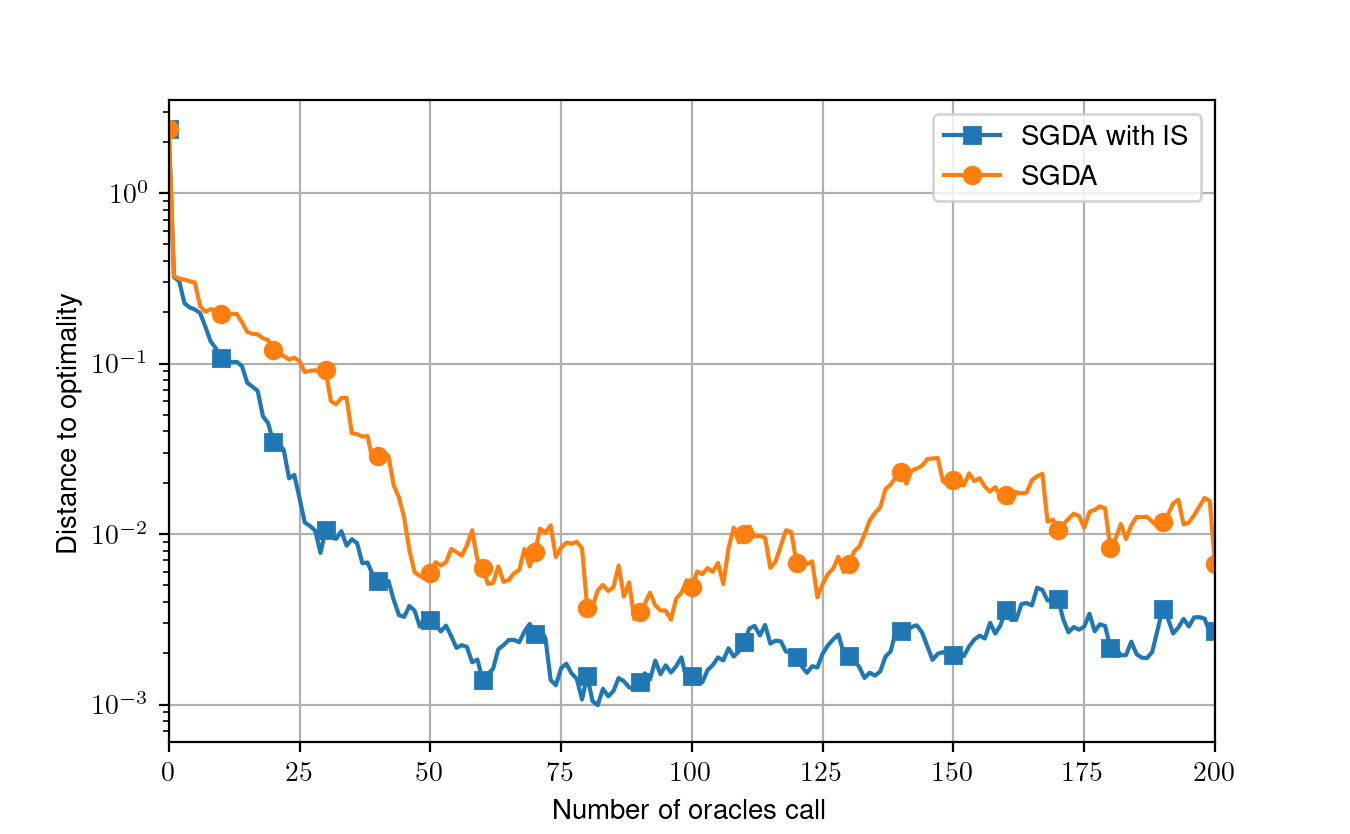

In [9]:
plt.figure(figsize=set_size(width))
plot_record(record_dict["importance_sampling"], label="SGDA with IS", marker="s", markevery=10)
plot_record(record_dict["uniform_sampling"], label="SGDA", marker="o", markevery=10)
plt.yscale("log")
plt.xlim(0, 200)
plt.xlabel("Number of oracles call")
plt.ylabel("Distance to optimality")
plt.grid()
plt.legend()
plt.savefig('figures/quadratic_prox_us_vs_is.pdf', bbox_inches='tight')